<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 8, style="color:rgb(200,0,0)"><b>Deep Learning</b></font></h1> 
<a href="mailto:rogerio.oliveira@mackenzie.br">Rogério de Oliveira</a><br>

<br>
<br>

---


<h1 align=left><font size = 6, style="color:rgb(200,0,0)">MLP com TensorFlow</font></h1>
<hr>

# **IMPORTANTE:** Antes de começar 

Execute a célula final desse Lab. Ela irá **inicializar** o seu ambiente com rotinas que são empregadas aqui.

O leitor deve ter em mente que comparar TensorFlow e Keras não é a melhor maneira de abordar a questão, já que Keras funciona como um wrapper para a estrutura do TensorFlow. Portanto, você pode definir um modelo com a interface de Keras, que é mais fácil de usar, e ir para o TensorFlow quando precisar usar um recurso que Keras não tem ou quando estiver procurando uma funcionalidade específica do TensorFlow. Assim, você pode colocar seu código TensorFlow diretamente no pipeline ou modelo de treinamento Keras.

O TensorFlow é uma plataforma de código-fonte aberto de ponta a ponta, uma biblioteca para várias tarefas de aprendizado de máquina, enquanto o Keras é uma biblioteca de rede neural de alto nível executada no TensorFlow. Ambos fornecem APIs de alto nível usadas para construir e treinar modelos facilmente, mas Keras é mais amigável porque é Python integrado.

|   |	Keras	| Pytorch	| TensorFlow |
|---|-------|---------|------------|
| API Level |	High	|Low	|High and Low|
| Architecture	|Simple, concise, readable|	Complex, less readable	|Not easy to use |
| Datasets	|Smaller datasets	|Large datasets, high performance|	Large datasets, high performance |
| Debugging	|Simple network, so debugging is not often needed|	Good debugging capabilities	|Difficult to conduct debugging|
| Does It Have Trained Models?	|Yes	|Yes|	Yes|
| Popularity	|Most popular	|Third most popular	|Second most popular|
| Speed	|Slow, low performance|	Fast, high-performance	|Fast, high-performance| 
| Written In	|Python	|Lua	|C++, CUDA, Python|

# **Case**: Detecção de Fraude em Operações de Cartão de Crédito

http://meusite.mackenzie.br/rogerio/ML/The-InfoQ-eMag-Introduction-to-Machine-Learning.pdf

Esse artigo trás uma ótima introdução ao Aprendizado de Máquina. O artigo demonstra a aplicação de dois modelos de classificação,**Árvores de Decisão e Regressão Logística**, para um conjunto de dado simples para detecção de fraude em operações de cartões de crédito. 

Aqui você vai empregar o mesmo conjunto de dados para um aprendizado de Deep Learning com **TensorFlow+Keras**. 

URL: https://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv

**IMPORTANTE** 
O uso de deeplearning pode ser bastante complexo e exigiria um bom tempo para estarmos aptos a empregar suas funções em diferentes problemas. Entenda esse exemplo como uma *degustação* do deep learning apenas para que você possa fixar os conceitos dessa técnica.

# Explorando os dados


In [2]:
# imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf

In [3]:
fraud = pd.read_csv("http://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
fraud.drop(columns=['charge_time'],inplace=True) # por simplicidade excluímos esse dado do treinamento
                     
print(fraud.head())
print(fraud.shape) 



   fraudulent  amount card_country  card_use_24h
0       False   20484           US             0
1       False    1211           US             0
2       False    8396           US             1
3       False    2359           US             0
4       False    1480           US             3
(89393, 4)


# Preparando os dados `X` e `y`

A preparação dos dados pode ser bastante complexa. Aqui ela envolve o **hot encode** dos atributos não numéricos, o rescaling dos dados e ainda a formatação dos dados para os padrões do **TensorFlow/Keras** (formato de matrizes e não dataframes).

## Hot Encode

In [6]:
X = fraud.drop(columns=['fraudulent'])
    
X_number = X.select_dtypes(include='number')
X_categorical = X.select_dtypes(exclude='number')
    
dummies = [pd.get_dummies(X[c],prefix=c, prefix_sep='_') for c in X_categorical.columns]
X_dummies = pd.concat(dummies, axis=1)

X = pd.concat([X_number,X_dummies], axis=1)
X.head()

,amount,card_use_24h,card_country_AU,card_country_GB,card_country_US
0,20484,0,0,0,1
1,1211,0,0,0,1
2,8396,1,0,0,1
3,2359,0,0,0,1
4,1480,3,0,0,1


## Normalize

### Scale

In [7]:
from sklearn.preprocessing import scale
X_norm = scale(X)
X_norm


array([[ 0.26867979, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.19763503, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.02379224, -0.1280861 , -0.15679634, -0.17828929,  0.2407913 ],
       ...,
       [ 6.07943233,  1.03882041, -0.15679634, -0.17828929,  0.2407913 ],
       [21.1991333 ,  0.99393939, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.12325887,  0.18608104, -0.15679634, -0.17828929,  0.2407913 ]])

### API StandardScaler

Prefira esse modo se você vai realmente implementar um `pipeline` de dados, *salvando* assim o `scaler` empregado.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X_norm



array([[ 0.26867979, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.19763503, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.02379224, -0.1280861 , -0.15679634, -0.17828929,  0.2407913 ],
       ...,
       [ 6.07943233,  1.03882041, -0.15679634, -0.17828929,  0.2407913 ],
       [21.1991333 ,  0.99393939, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.12325887,  0.18608104, -0.15679634, -0.17828929,  0.2407913 ]])

# Preparando a saída `y` 

Valores numéricos para a saída de rede.

In [11]:
fraud.fraudulent = fraud.fraudulent.replace(True,1)
fraud.fraudulent = fraud.fraudulent.replace(False,0)

y_num = fraud.fraudulent
y_num

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
89388    1.0
89389    1.0
89390    1.0
89391    1.0
89392    1.0
Name: fraudulent, Length: 89393, dtype: float64

## Separando os dados de Treinamento e Teste

In [16]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_num, test_size=0.3, random_state=seed)#stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(62575, 5) (26818, 5) (62575,) (26818,)


In [ ]:
y_train

15481    0.0
68476    1.0
62702    1.0
15586    0.0
21519    0.0
        ... 
22782    0.0
10869    0.0
12653    0.0
60631    1.0
2925     0.0
Name: fraudulent, Length: 62575, dtype: float64

# Adequando os dados para o `Keras`

Os dados para o `Keras` (TensorFlow) devem ser matrizes, com a saída em formato de um matriz binária (*hot encoded*).

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_train


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Configuração da Rede DeepLearning

Nossa rede será uma rede neural sequencial MLP. Há 5 neurônios de entrada, correspondendo a cada atributo de entrada, vamos criar duas camadas ocultas de 8 neurônios, e uma camada de saída com 2 neurônios correspondendo às duas classes de saída.





In [23]:
# Definição ou Configuração      saída       função de ativação    camada entrada
model = Sequential([layers.Dense(X.shape[1], activation='sigmoid', input_shape=[X.shape[1],])]) 

model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [21]:
[X.shape[1],]

[5]

# Treinamento da Rede DeepLearning

Os modelos neurais em geral trazem embutido no treinamento os conjuntos de validação. Assim, em geral, teremos um conjunto de *validação* e um conjunto de *teste*. O `history` permite salvar os dados do treinamento para análise do aprendizado, por exemplo *overfitting*. 

In [24]:
# Treinamento
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
1565/1565 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5330 - val_loss: 0.6644 - val_accuracy: 0.6038
Epoch 2/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6524 - accuracy: 0.6322 - val_loss: 0.6206 - val_accuracy: 0.6613
Epoch 3/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6165 - accuracy: 0.6667 - val_loss: 0.6128 - val_accuracy: 0.6683
Epoch 4/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6105 - accuracy: 0.6703 - val_loss: 0.6118 - val_accuracy: 0.6672
Epoch 5/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6116 - accuracy: 0.6687 - val_loss: 0.6102 - val_accuracy: 0.6700
Epoch 6/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6116 - accuracy: 0.6674 - val_loss: 0.6097 - val_accuracy: 0.6701
Epoch 7/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6097 - accuracy: 0.6685 - val_loss: 0.6098 - val_ac

# Avaliação do Modelo

Em geral,  diferentemente do que é mais comum em outros modelos de classificação não neurais, avalia-se o erro em substituição à acurácia.

O Treinamento busca a cada etapa minimizar o erro (aumentar a acuracidade). Isso entretanto não ocorre de maneira regular. O Treinamento pode ser concluído quando alcança um erro médio desejado ou após um certo número de iterações, uma vez que o modelo pode não convergir.

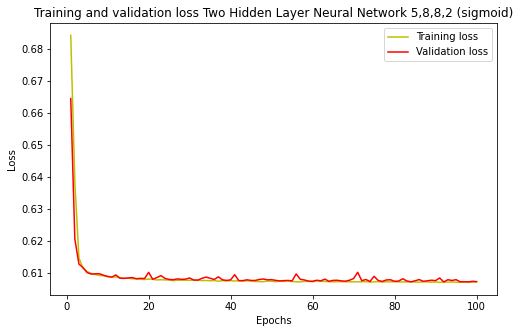

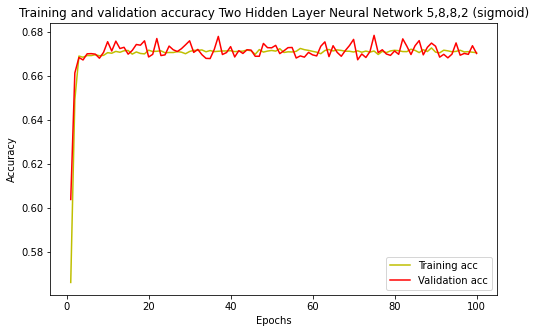

Two Hidden Layer Neural Network 5,8,8,2 (sigmoid)Accuracy Train: 67.05 %, Accuracy Test: 67.02 %


In [25]:
loss, val_loss, acc, val_acc = plot_loss_acc(history,'Two Hidden Layer Neural Network 5,8,8,2 (sigmoid)')


# Predição, aplicando e avaliando o modelo

Podemos então aplicar e avaliar o modelo no conjunto de teste.

Em cada neurônio de saída a rede retorna a probabilidade da classe. A seleção do neurônio de maior valor a classe mais provável (`np.argmax()`).

In [27]:
# Predict
print(model.predict(X_test))

y_pred = np.argmax(model.predict(X_test), axis=-1)
    
print(y_pred)
print(confusion_matrix(y_pred,y_test))


[[0.1473712  0.6655322 ]
 [0.43227744 0.40930614]
 [0.32428828 0.49539906]
 ...
 [0.5158497  0.34150797]
 [0.5093743  0.34675217]
 [0.44245976 0.4007496 ]]
[1 0 1 ... 0 0 0]
[[10327  5596]
 [ 3167  7728]]


In [28]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.77      0.65      0.70     15923
           1       0.58      0.71      0.64     10895

    accuracy                           0.67     26818
   macro avg       0.67      0.68      0.67     26818
weighted avg       0.69      0.67      0.68     26818



# Código completo

Aqui o código completo em uma única célula.

In [37]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf

fraud = pd.read_csv("http://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
fraud.drop(columns=['charge_time'],inplace=True)

In [44]:
## imports

# import numpy as np 
# import pandas as pd 
# import matplotlib.pyplot as plt 
# import seaborn as sns 
# import warnings
# import os
# warnings.filterwarnings("ignore")

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# from tensorflow import keras
# from tensorflow.keras import layers
# from keras import Sequential, layers
# import tensorflow as tf

# fraud = pd.read_csv("http://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
# fraud.drop(columns=['charge_time'],inplace=True) # por simplicidade excluímos esse dado do treinamento
                     
## Hot Encode

X = fraud.drop(columns=['fraudulent'])


# X_number = X.select_dtypes(include='number')
# X_categorical = X.select_dtypes(exclude='number')
    
# dummies = [pd.get_dummies(X[c],prefix=c, prefix_sep='_') for c in X_categorical.columns]
# X_dummies = pd.concat(dummies, axis=1)

# X = pd.concat([X_number,X_dummies], axis=1)
# X.head()

## Label Encode
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
X['card_country_label'] = labelencoder.fit_transform(X['card_country'])

## Normalize

# from sklearn.preprocessing import scale
# X_norm = scale(X)
# X_norm

X_norm = X
X_norm

## Preparando a saída `y` 

fraud.fraudulent = fraud.fraudulent.replace(True,1)
fraud.fraudulent = fraud.fraudulent.replace(False,0)

y_num = fraud.fraudulent
y_num

## Separando os dados de Treinamento e Teste 

seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_num, test_size=0.3, stratify=y_num, random_state=seed)

## Adequando categorical(y_train) para o `Keras`

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_train

## Configuração da Rede DeepLearning

model = Sequential([layers.Dense(X.shape[1], activation='sigmoid', input_shape=[X.shape[1],])]) 

model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Treinamento da Rede DeepLearning

history = model.fit(X_train, y_train, validation_split=0.2, epochs=20)

## Avaliação do Treinamento

loss, val_loss, acc, val_acc = plot_loss_acc(history,'Two Hidden Layer Neural Network 5,8,8,2 (sigmoid)')

## Predição, aplicando e avaliando o modelo

y_pred = np.argmax(model.predict(X_test), axis=-1)
    
print(y_pred)
print(confusion_matrix(y_pred,y_test))

print(classification_report(y_pred,y_test))

ValueError: ignored

# Exercício. 
Execute o modelo acima sem normalização dos dados. O modelo é sensível a normalização? 

O modelo fica um pouco pior: 
C/ Normalização +- 65%
S/ Normalização +- 57%


# Exercício. 
Execute o modelo agora empregando *label encode* do atributo `card_country`.

# Exercício. 
Agora varie parâmetros da rede neural, como número de camadas, número de neurônios e função de ativação. Veja se consegue obter um resultado significativamente melhor que os anteriores.

# Exercício. 
Empregue os modelos acima e refaça o treinamento dos dados de fraude incluindo agora o dia e o mês das operações.

## **LAB SET UP**
Execute antes de iniciar o Lab.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_loss_acc(history,more_title=''):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(more_title + 'Accuracy Train: {:.2f} %, Accuracy Test: {:.2f} %'.format(acc[len(acc)-1] *100, val_acc[len(val_acc)-1]*100))

    return loss, val_loss, acc, val_acc

print('Set Up completed!')    

Set Up completed!
